In [1]:
import numpy as np


In [13]:
dataset_eeg = np.load('dataset_eeg.npy')


In [19]:
np.save('dataset_eeg_0.npy', dataset_eeg[0])


In [2]:
dataset_eeg = np.load('dataset_eeg.npy')
dataset_image = np.load('dataset_image.npy')
dataset_label = np.load('dataset_label.npy')


In [3]:
dataset_eeg.shape


(505, 15, 400)

In [4]:
dataset_label.shape


(505,)

<Axes: ylabel='Count'>

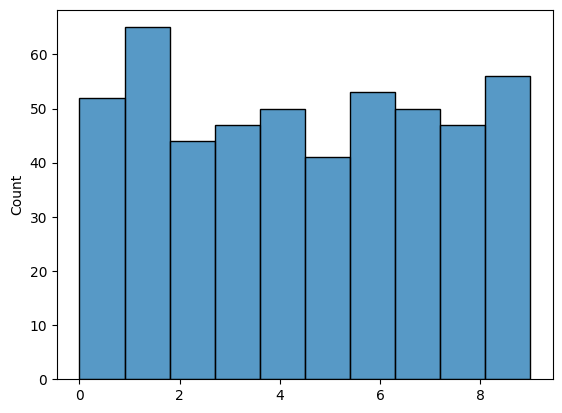

In [12]:
import seaborn as sns
sns.histplot(dataset_label)


In [5]:
dataset_eeg = dataset_eeg[:, 1:5]


In [6]:
dataset_eeg.shape


(505, 4, 400)

In [7]:
from datasets import Dataset, DatasetDict

dataset = Dataset.from_dict({'eeg': dataset_eeg, 'label': dataset_label})
dataset = dataset.train_test_split(test_size=0.1)


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
import numpy as np
from datasets import load_dataset
from transformers import CLIPTokenizerFast
from transformers.utils.logging import set_verbosity_warning

from trainable_clip_model import TrainableCLIPModel
from wavelet_spectrogram import cwt_spectrogram



# %%
# B, C, H, W
C = 4
H, W = 168, 400
L = 400
S = max(H, W)


# %%
map_digit_to_token = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}


# %%
tokenizer = CLIPTokenizerFast.from_pretrained("openai/clip-vit-large-patch14")

map_digit_to_input_ids = {
    digit: tokenizer(f"{map_digit_to_token[digit]}", padding=True).input_ids
    for digit in range(10)
}

def preprocess(inputs):
  B = len(inputs["label"])
  inputs["labels"] = inputs["label"]
  inputs["input_ids"] = [map_digit_to_input_ids[label] for label in inputs["label"]]
  inputs["attention_mask"] = [[1] * 3] * B
  samples = np.zeros((B, C, S, S))
  eeg = np.array(inputs["eeg"])
  for b in range(B):
    for i in range(C):
      sample = eeg[b, i]
      power, *_ = cwt_spectrogram(sample, 200, nNotes=24, detrend=True, normalize=True)
      samples[b, i, :min(H, S), :min(W, S)] = power.squeeze()
  inputs["pixel_values"] = samples
  return inputs


# %%
item = preprocess(dataset["train"][:8])
item["labels"], item["input_ids"], item['pixel_values'].shape


([3, 9, 7, 8, 2, 2, 2, 1],
 [[49406, 2368, 49407],
  [49406, 4629, 49407],
  [49406, 4558, 49407],
  [49406, 1158, 49407],
  [49406, 3329, 49407],
  [49406, 3329, 49407],
  [49406, 3329, 49407],
  [49406, 25258, 49407]],
 (8, 4, 400, 400))

In [9]:
# %%
remove_columns = ["eeg", "label"]


# %%
preprocessed_dataset = dataset.map(preprocess, batched=True, remove_columns=remove_columns)
print("done preprocessing!")
# %%
preprocessed_dataset.save_to_disk("our_data", num_proc=24)


Map:   0%|          | 0/454 [00:02<?, ? examples/s]


KeyboardInterrupt: 